In this first, we first reduce the rank then do the detection

In [1]:
import gtvdn_utils
import post_process
import utils
import importlib
importlib.reload(gtvdn_utils)
importlib.reload(post_process);
importlib.reload(utils);

In [52]:
from pathlib import Path
from scipy.io import loadmat
import numpy as np
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from gtvdn_utils import get_bspline_est , get_newdata, screening, dyna_prog, get_Nlogk
from post_process import est_eigvals, update_kp
from utils import paras2name, eig_sorted, euclidean_proj_l1ball
from tqdm import trange
%matplotlib inline

In [3]:
from scipy.stats import ttest_ind
import seaborn as sns

## Some functions

### Preprocess

In [4]:
# Preprocessing function
from scipy.signal import detrend, decimate
def preprocess_MEG(Ymats, paras):
    """args:
            Ymats: multiple MEG datasets, N x d x n, 
                   N is num of datasets, d is number of ROIs and n is the length of the sequences
            paras: Parameters for preprocess, dict
                   is_detrend: whether or detrend or not, Bool
                   decimate_rate: The rate to decimate from MEG data, reduce the resolution. If None, not decimate. Integer or None
    """
    # Decimate the data first
    decimate_rate = paras.decimate_rate
    if decimate_rate is not None:
        Ymats = decimate(Ymats, decimate_rate, ftype="fir")

    # Then Detrend the data
    is_detrend = paras.is_detrend
    if is_detrend:
        Ymats = detrend(Ymats)
            

    return Ymats

### Estimate Amat

In [5]:
from scipy.stats import iqr

def lowrankA(Amat, rankKp=30):
    eigVals, eigVecs = eig_sorted(Amat)
    # if breaking conjugate eigval pair, add rankKp with 1
    if (eigVals[rankKp-1].imag + eigVals[rankKp].imag ) == 0:
        rankKp = rankKp + 1
    redAmat = np.matmul(np.matmul(eigVecs[:, :rankKp], np.diag(eigVals[:rankKp])), np.linalg.inv(eigVecs)[:rankKp, :])
    return redAmat.real

# bw.nrd0 fn in R
def bwnrd0_py(x):
    hi = np.std(x, ddof=1)
    lo = np.min((hi, iqr(x)/1.34))
    eps = 1e-10
    if np.abs(lo-0) <= eps:
        if np.abs(hi-0) > eps:
            lo = hi
        elif np.abs(x[0]-0) > eps:
            lo = x[0]
        else:
            lo = 1
    rev = 0.9 * lo * len(x)**(-0.2)
    return rev   

# Function to obtain the sum of Ai matrix
def get_Amat(dXmats, Xmats, timeSpan, downrate=1, fct=1, nRks=10, is_sum=False):
    """
    Input: 
        dXmats: The first derivative of Xmats, N x d x n matrix
        Xmats: Xmat, N x d x n matrix
        timeSpan: A list of time points with length n
        downrate: The downrate factor, determine how many Ai matrix to be summed
        nRks# the rank to keep when estimating the Amat for each data
    Return:
        A d x d matrix, it is sum of N x n/downrate  Ai matrix
    """
    h = bwnrd0_py(timeSpan)*fct
    N, d, n = Xmats.shape
    if is_sum:
        Amat = np.zeros((d, d))
    else:
        Amat = np.eye(d)
    for ix in trange(N):
        Xmat, dXmat = Xmats[ix, :, :], dXmats[ix, :, :]
        curAmat = np.zeros((d, d))
        flag = 0
        for s in timeSpan[::downrate]:
            t_diff = timeSpan - s
            kernels = 1/np.sqrt(2*np.pi) * np.exp(-t_diff**2/2/h**2) # normal_pdf(x/h)
            kernelroot = kernels ** (1/2)
            kerdXmat = kernelroot[:, np.newaxis] * (dXmat.T) # n x d
            kerXmat = kernelroot[:, np.newaxis] * (Xmat.T) # n x d
            M = kerXmat.T.dot(kerXmat)/n
            XY = kerdXmat.T.dot(kerXmat)/n # it is Y\trans x X , formula is Amat = Y\trans X (X\trans X)^{-1}
            U, S, VT = np.linalg.svd(M)
            # Num of singular values to keep
            r = np.argmax(np.cumsum(S)/np.sum(S) >= 0.999) + 1 # For real data
            invM = VT.T[:, :r].dot(np.diag(1/S[:r])).dot(U.T[:r, :]) # M is symmetric and PSD
            curAmat = curAmat + XY.dot(invM)
            flag += 1
            
        if is_sum:
            Amat = Amat + lowrankA(curAmat/flag, nRks)
        else:
            curAmat = curAmat/np.sqrt(flag)
            Amat = np.matmul(Amat, curAmat)
    return Amat



# Function to obtain the sum of Ai matrix
def get_Amats(dXmats, Xmats, timeSpan, downrate=1, fct=1, nRks=10, is_sum=False):
    """
    Input: 
        dXmats: The first derivative of Xmats, N x d x n matrix
        Xmats: Xmat, N x d x n matrix
        timeSpan: A list of time points with length n
        downrate: The downrate factor, determine how many Ai matrix to be summed
        nRks# the rank to keep when estimating the Amat for each data
    Return:
        A d x d matrix, it is sum of N x n/downrate  Ai matrix
    """
    h = bwnrd0_py(timeSpan)*fct
    N, d, n = Xmats.shape
    Amats = []
    AmatsLow = []
    for ix in trange(N):
        Xmat, dXmat = Xmats[ix, :, :], dXmats[ix, :, :]
        curAmat = np.zeros((d, d))
        flag = 0
        for s in timeSpan[::downrate]:
            t_diff = timeSpan - s
            kernels = 1/np.sqrt(2*np.pi) * np.exp(-t_diff**2/2/h**2) # normal_pdf(x/h)
            kernelroot = kernels ** (1/2)
            kerdXmat = kernelroot[:, np.newaxis] * (dXmat.T) # n x d
            kerXmat = kernelroot[:, np.newaxis] * (Xmat.T) # n x d
            M = kerXmat.T.dot(kerXmat)/n
            XY = kerdXmat.T.dot(kerXmat)/n # it is Y\trans x X , formula is Amat = Y\trans X (X\trans X)^{-1}
            U, S, VT = np.linalg.svd(M)
            # Num of singular values to keep
            r = np.argmax(np.cumsum(S)/np.sum(S) >= 0.999) + 1 # For real data
            invM = VT.T[:, :r].dot(np.diag(1/S[:r])).dot(U.T[:r, :]) # M is symmetric and PSD
            curAmat = curAmat + XY.dot(invM)
            flag += 1
            
        Amats.append(curAmat/flag)
        AmatsLow.append(lowrankA(curAmat/flag, nRks))
    return AmatsLow



### misc

In [6]:
comsum_percent = lambda x: np.cumsum(np.abs(x))/np.sum(np.abs(x))

In [7]:
def euclidean_proj_l1ball_cplx(curVal, L):
    curValAbs = np.abs(curVal)
    redValAbs = euclidean_proj_l1ball(curValAbs.copy(), L)
    ratioValAbs = redValAbs/curValAbs
    redVal = curVal * ratioValAbs
    return redVal

def euclidean_proj_l1ball_cplxmat(curMat, L):
    curMatAbs = np.abs(curMat)
    rowNorms = np.sum(np.abs(curMatAbs), axis=1)
    redRowNorms = euclidean_proj_l1ball(rowNorms.copy(), L)
    rowNorms[rowNorms==0] = 1e-5 # avoid divided-by-0 error
    ratioVec = redRowNorms/rowNorms
    curMatRed = ratioVec.reshape(-1, 1) * curMat
    return curMatRed, redRowNorms

def euclidean_proj_l1ball_cplxmul(eigValsMat, L1):
    singleRedCurValList = []
    for ix in range(eigValsMat.shape[-1]):
        curVal = eigValsMat[:, ix]
        redCurVal = euclidean_proj_l1ball_Cplx(curVal.copy(), L1)
        singleRedCurValList.append(redCurVal)
    singleRedCurValMat = np.array(singleRedCurValList).T
    return singleRedCurValMat

In [8]:
def idenCPD(res):
    """
    args:
        res: the results from parafac function with normalize_factors=True
    return:
        For a D-dim tensor, normalize the first (D-1) components with L2 norm 1  and
                            sort the vector in the last model via its L2 norm.
    """
    factors = res.factors
    weights = res.weights
    sortIdxs = np.argsort(-weights)
    weightsSorted = weights[sortIdxs]
    factorsSorted = [factor[:, sortIdxs] for factor in factors]
    res.weights = np.ones_like(weightsSorted)
    res.factors = factorsSorted
    res.factors[-1] = factorsSorted[-1] * weightsSorted
    return res

def minmax_mat(Mat, is_row=True):
    if is_row:
        mins = np.min(Mat, axis=1)[:, np.newaxis]
        maxs = np.max(Mat, axis=1)[:, np.newaxis]
    else:
        mins = np.min(Mat, axis=0)[np.newaxis, :]
        maxs = np.max(Mat, axis=0)[np.newaxis, :]
    rv = (Mat-mins)/(maxs-mins)
    return rv

In [9]:
import tensorly as tl
import tensortools as tt
from tensortools.operations import unfold as tt_unfold, khatri_rao

def decompose_three_way_orth(tensor, rank, max_iter=501, verbose=False, init=None):

    if init is None:
        aT, _ = np.linalg.qr(np.random.random((rank, tensor.shape[0])).T)
        a = aT.T
        bT, _ = np.linalg.qr(np.random.random((rank, tensor.shape[1])).T)
        b = bT.T
        #c = np.random.random((rank, tensor.shape[2]))
    else:
        aT, bT = init
        a, b = aT.T, bT.T

    for epoch in range(max_iter):
        # optimize c
        input_c = khatri_rao([a.T, b.T])
        target_c = tl.unfold(tensor, mode=2).T
        c = np.linalg.solve(input_c.T.dot(input_c), input_c.T.dot(target_c))
        
        # optimize a
        input_a = khatri_rao([b.T, c.T])
        target_a = tl.unfold(tensor, mode=0).T
        a = np.linalg.solve(input_a.T.dot(input_a), input_a.T.dot(target_a))
        aT, _ = np.linalg.qr(a.T)
        a = aT.T
        #a = orth(a.T).T

        # optimize b
        input_b = khatri_rao([a.T, c.T])
        target_b = tl.unfold(tensor, mode=1).T
        b = np.linalg.solve(input_b.T.dot(input_b), input_b.T.dot(target_b))
        bT, _ = np.linalg.qr(b.T)
        b = bT.T
        #b = orth(b.T).T


        if verbose and epoch % int(max_iter * .10) == 0:
            res_a = np.square(input_a.dot(a) - target_a)
            res_b = np.square(input_b.dot(b) - target_b)
            res_c = np.square(input_c.dot(c) - target_c)
            print("Epoch:", epoch, "| Loss (C):", res_a.mean(), "| Loss (B):", res_b.mean(), "| Loss (C):", res_c.mean())

    return a.T, b.T, c.T

def decompose_three_way_orth_fix(tensor, init=None):

    aT, bT = init
    a, b = aT.T, bT.T

    input_c = khatri_rao([a.T, b.T])
    target_c = tl.unfold(tensor, mode=2).T
    c = np.linalg.solve(input_c.T.dot(input_c), input_c.T.dot(target_c))
        
    return a.T, b.T, c.T

In [10]:
def sort_orthCPD(res):
    """
    args:
        res: a, b, c
    return:
        For the 3-dim tensor,  sort the vector in the last model via its L2 norm.
    """
    B1, B2, B3 = res
    ws = np.sum(B3**2, axis=0)
    sortIds = np.argsort(-ws)
    sortB1 = B1[:, sortIds]
    sortB2 = B2[:, sortIds]
    sortB3 = B3[:, sortIds]
    return sortB1, sortB2, sortB3

In [11]:
def cumsum_cutoff(vec, cutoff=0.8):
    sorted_idx = np.argsort(-vec)
    ratio_vec = np.cumsum(vec[sorted_idx])/np.sum(vec)
    rank = np.sum(ratio_vec <cutoff) + 1
    keep_idx = np.sort(sorted_idx[:rank])
    return keep_idx

## Load data

In [12]:
dataDir = Path("../data")
resDir = Path("../results")

In [13]:
datFil = list(dataDir.glob("70Ctrl*"))[0]
CtrlDat1 = loadmat(datFil)
CtrlDats = CtrlDat1["dk10"]

In [14]:
datFil = list(dataDir.glob("87AD*"))[0]
ADDat1 = loadmat(datFil)
ADDats = ADDat1["dk10"]

In [15]:
ADdatAdd = loadmat(dataDir/"DK_timecourse.mat")["DK_timecourse"]

In [16]:
import mat73
CtrldatAdd = mat73.loadmat(dataDir/"timecourse_ucsfCONT_group.mat")["dk10"]

In [17]:
baseDF = pd.read_csv(dataDir/"AllDataBaselineOrdered.csv")
CtrlKp = np.array(baseDF[baseDF["Grp"]=="Ctrl"]["KeepIt"] == 1)

In [18]:
ADDatsAll = np.concatenate([ADDats, ADdatAdd[np.newaxis, :, :]], axis=0)
CtrlDatsAll = np.concatenate([CtrlDats, CtrldatAdd], axis=0)
CtrlDatsAll = CtrlDatsAll[CtrlKp]

## Set parameters

In [32]:
paras = edict()
paras.is_detrend = True
paras.decimate_rate = 5
paras.T = 2 # the total time course
paras.lamb = 1e-4 # the smooth parameter for smooth spline
paras.fct = 0.5 #fct: The factor to adjust h when estimating A matrix
paras.downsample_rate = 20#the downsample factor, determine how many Ai matrix to contribute to estimate the eigen values/vectors
paras.r = 20 #    r: The rank of A matrix, 
             # If r is decimal, the rank is the number of eigen values which account for 100r % of the total variance
             # If r is integer, the r in algorithm can be r + 1 if r breaks the conjugate eigval pairs. 
paras.Lmin = 200 # Lmin: The minimal length between 2 change points
paras.maxM = 20 #  MaxM: int, maximal number of change point 
paras.kappa = 3.210 #kappa: The parameter of penalty in MBIC
paras.wh = 20 # screening window size
paras.kps =  np.linspace(1, 4, 1000)
paras.save_dir = Path("./")
paras.L = 1e2 # the  L1-ball projectoin radius
paras.num_ranks = 10 # the rank to keep when estimating the Amat for each data
paras.cutoff = 0.6

## Run 

In [22]:
Ymat_ctrl = preprocess_MEG(CtrlDatsAll[:], paras)
Ymat_AD = preprocess_MEG(ADDatsAll[:], paras)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [00:46<00:00,  1.90it/s]


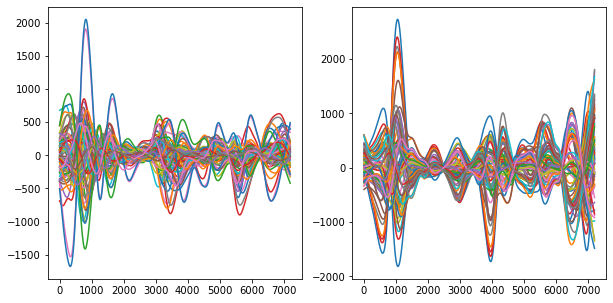

In [23]:
time_span = np.linspace(0, paras.T, Ymat_AD.shape[-1])

dXmats_AD, Xmats_AD = get_bspline_est(Ymat_AD, time_span, paras.lamb)
dXmats_ctrl, Xmats_ctrl = get_bspline_est(Ymat_ctrl, time_span, paras.lamb)

plt.figure(figsize=[10, 5])
plt.subplot(121)
for ix in range(68):
    plt.plot(Xmats_AD[0, ix, :])
plt.subplot(122)
for ix in range(68):
    plt.plot(Xmats_ctrl[0, ix, :])

### CP decomposition

In [24]:
import tensorly as tl
from tensorly.decomposition import parafac

In [25]:
Amat_ctrls_lowrank = get_Amats(dXmats_ctrl[:], Xmats_ctrl[:], time_span, downrate=paras.downsample_rate, 
                              fct=paras.fct, nRks=paras.num_ranks, is_sum=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [04:27<00:00,  3.04s/it]


In [26]:
Amat_ADs_lowrank = get_Amats(dXmats_AD[:], Xmats_AD[:], time_span, downrate=paras.downsample_rate, 
                            fct=paras.fct, nRks=paras.num_ranks, is_sum=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [04:25<00:00,  3.02s/it]


In [27]:
# rank-R decomposition
tensors_ctrl = np.transpose(np.array(Amat_ctrls_lowrank), (1, 2, 0))
tensors_AD = np.transpose(np.array(Amat_ADs_lowrank), (1, 2, 0))

# the initial value 
Amat_ctrl_lowrank = np.sum(Amat_ctrls_lowrank, axis=0)
U, _, VT = np.linalg.svd(Amat_ctrl_lowrank)
ctrl_CPD_init = [U[:, :paras.r], VT.T[:, :paras.r]]

CPDresult_ctrl = sort_orthCPD(decompose_three_way_orth(tensors_ctrl, paras.r, init=ctrl_CPD_init))
CPDresult_AD = decompose_three_way_orth_fix(tensors_AD, init=[CPDresult_ctrl[0], CPDresult_ctrl[1]])


In [28]:
names =["AD", "ctrl"]
CPDress = edict()
CPDress["AD"]= CPDresult_AD
CPDress["ctrl"]= CPDresult_ctrl

In [42]:
keep_idxs_AD = [cumsum_cutoff(np.abs(CPDresult_AD[-1])[ix, :], paras.cutoff) for ix in range(len(CPDresult_AD[-1]))]
keep_idxs_ctrl = [cumsum_cutoff(np.abs(CPDresult_ctrl[-1])[ix, :], paras.cutoff) for ix in range(len(CPDresult_ctrl[-1]))]

#### CPD factors

In [46]:
orgFn = lambda x: np.abs(x)
mmFn = lambda x: minmax_mat(np.abs(x), is_row)
cutFn = lambda x: minmax_mat(np.abs(x), is_row)>cutoff
def heat_plot(idx, curFn):
    plt.figure(figsize=[20, 10])
    for ix, nam in enumerate(names):
        plt.subplot(1, 2, ix+1)
        curRes = CPDress[nam]
        sns.heatmap(curFn(curRes[idx]))
        plt.title(nam)

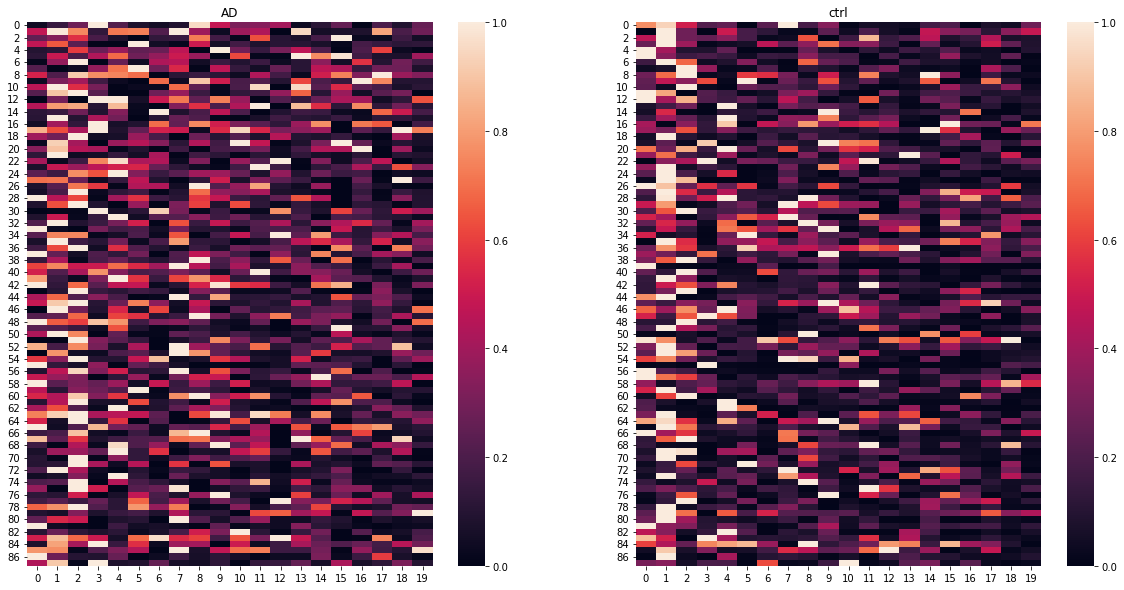

In [47]:
cutoff = 0.5
is_row = True
heat_plot(2, mmFn)
#heatPlotFn(2, mmFn)

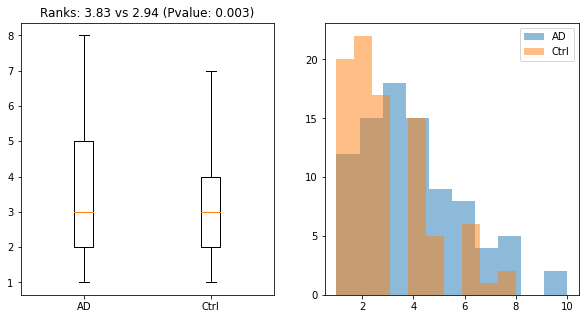

In [48]:
cutoff = 0.5
rksAD = cutFn(CPDress["AD"][-1]).sum(axis=1)
rksCtrl = cutFn(CPDress["ctrl"][-1]).sum(axis=1)
plt.figure(figsize=[10, 5])
plt.subplot(121)
_ = plt.boxplot([rksAD, rksCtrl], showfliers=False)
pval = ttest_ind(rksAD, rksCtrl, equal_var=False).pvalue
plt.xticks([1, 2], ["AD", "Ctrl"])
plt.title(f"Ranks: {np.mean(rksAD):.2f} vs {np.mean(rksCtrl):.2f} (Pvalue: {pval:.3f})")

plt.subplot(122)
plt.hist(rksAD, alpha=0.5, label="AD")
plt.hist(rksCtrl, alpha=0.5, label="Ctrl")
plt.legend()

#### corrs with 7 networks

In [49]:
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
def minmax(x):
    rev = (x - np.min(x))/(np.max(x) - np.min(x))
    return rev

defNetsFil = list(dataDir.glob("DK_dic68.csv"))[0]
defNets = pd.read_csv(defNetsFil).T

mmDefNets = {}
for ix in range(defNets.shape[-1]):
    curCol = defNets[ix]
    mmDefNets[curCol[0]] = minmax(np.array(curCol[1:]))
kysOrd = sorted(mmDefNets.keys())

In [50]:
idx = 0
corrMats = edict()
for ix, nam in enumerate(names):
    curRes = CPDress[nam]
    curUs = np.abs(curRes[idx])
    corrMat = np.zeros((7, curUs.shape[-1]))
    for iy in range(curUs.shape[-1]):
        curU = minmax(curUs[:, iy])
        for iz, kz in enumerate(kysOrd):
            curV = mmDefNets[kz]
            corrMat[iz, iy] = pearsonr(curU, curV)[0]
    corrMats[nam] = corrMat

In [51]:
def corr_plot():
    plt.figure(figsize=[15, 10])
    for ix, nam in enumerate(names):
        plt.subplot(2, 1, ix+1)
        curMat= corrMats[nam]
        sns.heatmap(curMat,  yticklabels=kysOrd, cmap="coolwarm", center=0, vmin=-1, vmax=1, annot=np.round(curMat, 2))
        plt.title(nam)

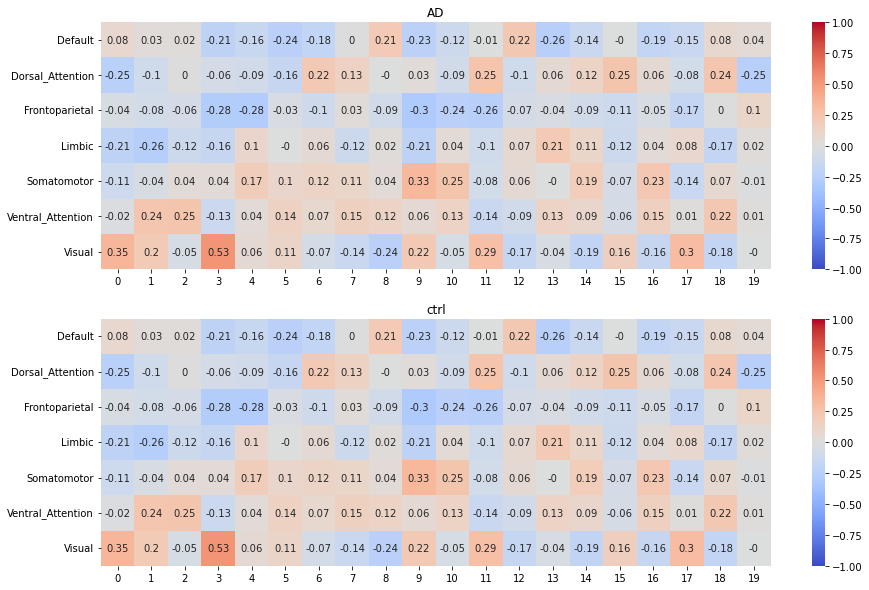

In [52]:
corr_plot()

### Reduce the dim of the data

In [43]:
B1 = CPDresult_ctrl[0]
B2 = CPDresult_ctrl[1]
ndXmats_ctrl =  [np.matmul(B1.T[keep_idxs_ctrl[ix], :], dXmats_ctrl[ix]) for ix in range(len(dXmats_ctrl))]
nXmats_ctrl =  [np.matmul(B2.T[keep_idxs_ctrl[ix], :], Xmats_ctrl[ix]) for ix in range(len(Xmats_ctrl))]

ndXmats_AD =  [np.matmul(B1.T[keep_idxs_AD[ix], :], dXmats_AD[ix]) for ix in range(len(dXmats_AD))]
nXmats_AD =  [np.matmul(B2.T[keep_idxs_AD[ix], :], Xmats_AD[ix]) for ix in range(len(Xmats_AD))]


### Screening

In [47]:
# Function to calculate the  Gamma_k matrix during dynamic programming for CP Decomposition
def get_gammak_4CPD(Ycur, Xcur):
    """
    Input: 
        Ycur: part of ndXmat, r x (j-i)
        Xcur: part of nXmat, r x (j-i)
    Return:
        Gamma matrix, r x r
    """
    r = Ycur.shape[0]
    GamMat = np.zeros((r, r))
    for ix in range(r):
        rY, rX = Ycur[ix, :], Xcur[ix, :]
        GamMat[ix, ix] = (rY.dot(rX))/(rX.dot(rX))
    return GamMat

In [50]:
def screening_4CPD(ndXmats, nXmats, wh=10, showProgress=True):
    """
    Input:
        wh: screening window size
    """
    # Get the scanning stats at index k
    def _get_scan_stats(k, wh):
        lidx = k - wh + 1
        uidx = k + wh + 1

        pndXmatA = ndXmat[:, lidx:uidx]
        pnXmatA = nXmat[:, lidx:uidx]
        GamkA = get_gammak_4CPD(pndXmatA, pnXmatA)
        nlogA = get_Nlogk(pndXmatA, pnXmatA, GamkA)

        pndXmatL = ndXmat[:, lidx:(k+1)]
        pnXmatL = nXmat[:, lidx:(k+1)]
        GamkL = get_gammak_4CPD(pndXmatL, pnXmatL)
        nlogL = get_Nlogk(pndXmatL, pnXmatL, GamkL)

        pndXmatR = ndXmat[:, (k+1):uidx]
        pnXmatR = nXmat[:, (k+1):uidx]
        GamkR = get_gammak_4CPD(pndXmatR, pnXmatR)
        nlogR = get_Nlogk(pndXmatR, pnXmatR, GamkR)

        return nlogR + nlogL - nlogA

    N = len(ndXmats)
    _, n = ndXmats[0].shape
    canptss = []
    if showProgress:
        iterBar = trange(N, desc="Screening")
    else:
        iterBar = range(N)
    for ix in iterBar:
        ndXmat, nXmat = ndXmats[ix], nXmats[ix]
        scanStats = []
        for iy in range(n):
            if iy < (wh-1):
                scanStats.append(np.inf)
            elif iy >= (n-wh):
                scanStats.append(np.inf)
            else:
                scanStats.append(_get_scan_stats(iy, wh))

        canpts = []
        for idx, scanStat in enumerate(scanStats):
            if (idx >= (wh-1)) and (idx < (n-wh)):
                lidx = idx - wh + 1
                uidx = idx + wh + 1
                if scanStat == np.min(scanStats[lidx:uidx]):
                    canpts.append(idx) # the change point is from 0 not 1

        canptss.append(canpts)
    return canptss

In [53]:
candidate_pts_ctrls = screening_4CPD(ndXmats_ctrl, nXmats_ctrl, wh=paras.wh)
candidate_pts_ADs = screening_4CPD(ndXmats_AD, nXmats_AD, wh=paras.wh)

Screening: 100%|██████████████████████████████████████████████████████████████████████████████████████| 88/88 [10:00<00:00,  6.82s/it]


### Detection

In [54]:
# Effcient dynamic programming to optimize the MBIC, 
def dyna_prog_4CPD(ndXmat, nXmat, kappa, Lmin=None, canpts=None, maxM=None, is_full=False, Ms=None, showProgress=True):
    """
    Input:
    ndXmat: array, r x n. n is length of sequence. 
    nXmat: array, r x n. n is length of sequence. 
    kappa: The parameter of penalty
    Lmin: The minimal length between 2 change points
    canpts: candidate point set. list or array,  index should be from 1
    maxM: int, maximal number of change point 
    Ms: the list containing prespecified number of change points.
       When Ms=None, it means using MBIC to determine the number of change points
    is_full: Where return full outputs or not
    Return:
        change point set with index starting from 1
        chgMat: A matrix containing the change points for each number of change point
        U0: MBIC without penalty
        U:  MBIC  for each number of change point
    """
    def _nloglk(i, j):
        length = j - i + 1
        pndXmat = ndXmat[:, i:(j+1)]
        pnXmat = nXmat[:, i:(j+1)]
        Gamk = get_gammak_4CPD(pndXmat, pnXmat)
        if length >= Lmin:
            return get_Nlogk(pndXmat, pnXmat, Gamk)
        else:
            return decon 

    r, n = nXmat.shape
    if Lmin is None:
        Lmin = r
        
    decon = np.inf

    if Ms is not None:
        Ms = sorted(Ms)
    if canpts is None:
        canpts = np.arange(n-1)
    else:
        canpts = np.array(canpts)
    M0 = len(canpts) # number of change point in candidate point set

    if (maxM is None) or (maxM>M0):
        maxM = M0 
    if not (Ms is None or len(Ms)==0):
        maxM = Ms[-1] if Ms[-1]>=maxM else maxM
    canpts_full = np.concatenate(([-1], canpts, [n-1]))
    canpts_full2 = canpts_full[1:]
    canpts_full1 = canpts_full[:-1] + 1 # small

    Hmat = np.zeros((M0+1, M0+1)) + decon

    # create a matrix 
    if showProgress:
        proBar = trange(M0+1, desc="Dynamic Programming")
    else:
        proBar = range(M0+1)
    for ix in proBar:
        for jx in range(ix, M0+1):
            iidx, jjdx = canpts_full1[ix],  canpts_full2[jx]
            Hmat[ix, jx]  = _nloglk(iidx, jjdx)

    # vector contains results for each number of change point
    U = np.zeros(maxM+1) 
    U[0] = Hmat[0, -1]
    D = Hmat[:, -1]
    # contain the location of candidate points  (in python idx)
    Pos = np.zeros((M0+1, maxM)) + decon
    Pos[M0, :] = np.ones(maxM) * M0
    tau_mat = np.zeros((maxM, maxM)) + decon
    for k in range(maxM):
        for j in range(M0): # n = M0 + 1
            dist = Hmat[j, j:-1] + D[(j+1):]
            #print(dist)
            D[j] = np.min(dist)
            Pos[j, 0] = np.argmin(dist) + j + 1
            if k > 0:
                Pos[j, 1:(k+1)] = Pos[int(Pos[j, 0]), 0:k]
        U[k+1] = D[0]
        tau_mat[k, 0:(k+1)] = Pos[0, 0:(k+1)] - 1
    U0 = U 
    U = U + 2*r*np.log(n)**kappa* (np.arange(1, maxM+2))
    chgMat = np.zeros(tau_mat.shape) + np.inf
    for iii in range(chgMat.shape[0]):
        idx = tau_mat[iii,: ]
        idx = np.array(idx[idx<np.inf], dtype=int)
        chgMat[iii, :(iii+1)]= np.array(canpts)[idx] + 1 
    
    mbic_numchg = np.argmin(U[:(maxM+1)])
    if mbic_numchg == 0:
        mbic_ecpts = np.array([])
    else:
        idx = tau_mat[int(mbic_numchg-1),: ]
        idx = np.array(idx[idx<np.inf], dtype=int)
        mbic_ecpts = np.array(canpts)[idx] + 1
        
    if Ms is None or len(Ms)==0:
        if not is_full:
            return edict({"U":U, "mbic_ecpts": mbic_ecpts})
        else:
            return edict({"U":U, "mbic_ecpts": mbic_ecpts, "chgMat": chgMat, "U0":U0})
    else:
        ecptss = []
        for numchg in Ms:
            if numchg == 0:
                ecpts = np.array([])
            else:
                idx = tau_mat[int(numchg-1),: ]
                idx = np.array(idx[idx<np.inf], dtype=int)
                ecpts = np.array(canpts)[idx] + 1
            ecptss.append(ecpts)
        if not is_full:
            return edict({"U":U, "ecptss": ecptss, "mbic_ecpts": mbic_ecpts})
        else:
            return edict({"U":U, "ecptss": ecptss, "mbic_ecpts": mbic_ecpts, "chgMat": chgMat, "U0":U0})

In [55]:
cpts_ctrls = []
for ix in trange(len(candidate_pts_ctrls)):
    res = dyna_prog_4CPD(ndXmats_ctrl[ix], nXmats_ctrl[ix], paras.kappa, Lmin=paras.Lmin,  canpts=candidate_pts_ctrls[ix], 
                     maxM=paras.maxM,  is_full=True,  showProgress=False)
    cpts_ctrls.append(res)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [17:35<00:00, 12.00s/it]


In [56]:
cpts_ADs = []
for ix in trange(len(candidate_pts_ADs)):
    res = dyna_prog_4CPD(ndXmats_AD[ix], nXmats_AD[ix], paras.kappa, Lmin=paras.Lmin,  canpts=candidate_pts_ADs[ix], 
                     maxM=paras.maxM,  is_full=True,  showProgress=False)
    cpts_ADs.append(res)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [17:15<00:00, 11.77s/it]


### Save the results

In [57]:
results = edict()
results.paras = paras

results.AD = edict()
results.AD.cpts = cpts_ADs
results.AD.candidate_pts = candidate_pts_ADs
results.AD.ndXmats = ndXmats_AD
results.AD.nXmats = nXmats_AD
results.AD.CPDres = CPDresult_AD

results.ctrl = edict()
results.ctrl.cpts = cpts_ctrls
results.ctrl.candidate_pts = candidate_pts_ctrls
results.ctrl.ndXmats = ndXmats_ctrl
results.ctrl.nXmats = nXmats_ctrl
results.ctrl.CPDres = CPDresult_ctrl

In [58]:
with open(paras.save_dir/"CPD_results_detect_after.pkl", "wb") as f:
    pickle.dump(results, f)

### Post Processing

#### Select kappa
not work

In [67]:
# sel kappa
cpts_ctrls_allkp = []
_, n = nXmats_ctrl[-1].shape
for kp in paras.kps:
    cpts_ctrl_allkp = np.array([update_kp(kp, cpts_ctrl.U0, n, len(keep_idxs_ctrl[ix]), paras) for ix, cpts_ctrl in enumerate(cpts_ctrls)])
    cpts_ctrls_allkp.append(cpts_ctrl_allkp)
    

cpts_ADs_allkp = []
_, n = nXmats_AD[-1].shape
for kp in paras.kps:
    cpts_AD_allkp = np.array([update_kp(kp, cpts_AD.U0, n, len(keep_idxs_AD[ix]), paras) for ix, cpts_AD in enumerate(cpts_ADs)])
    cpts_ADs_allkp.append(cpts_AD_allkp)

2.786786786786787

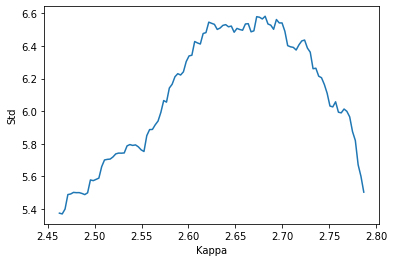

In [78]:
cpts_ctrls_allkp = np.array(cpts_ctrls_allkp)
cpts_ADs_allkp = np.array(cpts_ADs_allkp)
cpts_ctrl_std = cpts_ctrls_allkp.std(axis=1)
cpts_ctrl_mean = cpts_ctrls_allkp.mean(axis=1)

kps_keepidx_ctrl = np.bitwise_and(cpts_ctrls_allkp.mean(axis=1)>=7, cpts_ctrls_allkp.mean(axis=1)<=18)


plt.plot(paras.kps[kps_keepidx_ctrl], cpts_ctrl_std[kps_keepidx_ctrl])
plt.xlabel("Kappa")
plt.ylabel("Std")


sel_kp = paras.kps[kps_keepidx_ctrl][np.argmin(cpts_ctrl_std[kps_keepidx_ctrl])]
sel_kp = paras.kps[kps_keepidx_ctrl][-1]
sel_kp

#### Select cutoff for rank

not work

In [782]:
cutoffs = np.arange(0, 1, 0.01)
rank_ADs_allcutoff = []
rank_ctrls_allcutoff = []
for cur_cutoff in cutoffs:
    #cur_rank_ADs = np.sum(minmax_mat(np.abs(CPDresult_AD[2]), is_row=True) > cur_cutoff, axis=1)
    #cur_rank_ctrls = np.sum(minmax_mat(np.abs(CPDresult_ctrl[2]), is_row=True) > cur_cutoff, axis=1)
    cur_rank_ADs = np.array([len(cumsum_cutoff(np.abs(CPDresult_AD[2][ix]), cur_cutoff)) for ix in range(len(CPDresult_AD[2]))])
    cur_rank_ctrls = np.array([len(cumsum_cutoff(np.abs(CPDresult_ctrl[2][ix]), cur_cutoff)) for ix in range(len(CPDresult_ctrl[2]))])
    rank_ADs_allcutoff.append(cur_rank_ADs)
    rank_ctrls_allcutoff.append(cur_rank_ctrls)

Text(0, 0.5, 'Std')

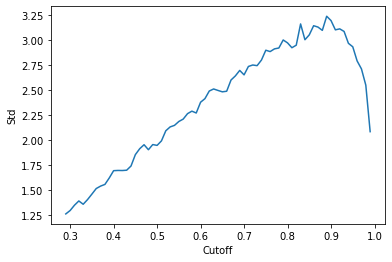

In [783]:
ranks_ADs_allcutoff = np.array(rank_ADs_allcutoff)
ranks_ctrls_allcutoff = np.array(rank_ctrls_allcutoff)
ranks_2grp_std = ranks_ADs_allcutoff.std(axis=1) + ranks_ctrls_allcutoff.std(axis=1)
ranks_2grp_mean = ranks_ADs_allcutoff.mean(axis=1) + ranks_ctrls_allcutoff.mean(axis=1)

cutoffs_keepidx_ctrl = np.bitwise_and(ranks_ctrls_allcutoff.mean(axis=1)>=2, 
                                      ranks_ctrls_allcutoff.mean(axis=1)<=18)
cutoffs_keepidx_AD = np.bitwise_and(ranks_ADs_allcutoff.mean(axis=1)>=2, 
                                    ranks_ADs_allcutoff.mean(axis=1)<=18)
cutoffs_keepidx_2grp = np.bitwise_and(cutoffs_keepidx_AD, cutoffs_keepidx_ctrl)


plt.plot(cutoffs[cutoffs_keepidx_2grp], ranks_2grp_std[cutoffs_keepidx_2grp])
plt.xlabel("Cutoff")
plt.ylabel("Std")


# NOT  WORK

0.41000000000000003

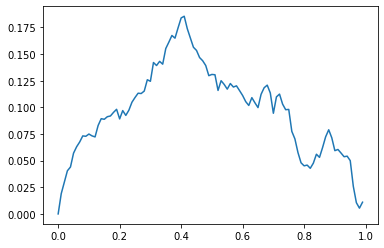

In [311]:
ranks_diff_rate = np.abs(ranks_ADs_allcutoff.mean(axis=1)/ranks_2grp_mean-  ranks_ctrls_allcutoff.mean(axis=1)/ranks_2grp_mean)
plt.plot(cutoffs, ranks_diff_rate)
sel_cutoff = cutoffs[np.argmax(ranks_diff_rate)]
sel_cutoff

#### Change points under the selected kappa

In [79]:
cur_kp = sel_kp
_, n = ndXmats_ctrl[-1].shape
ncpts_ctrls_selected = np.array([update_kp(cur_kp, cpts_ctrl.U0, n, len(keep_idxs_ctrl[ix]), paras) for ix, cpts_ctrl in enumerate(cpts_ctrls)])
cpts_ctrls_selected = [cur_cpts.chgMat[cur_ncpt-1, :cur_ncpt] for cur_ncpt, cur_cpts in zip(ncpts_ctrls_selected, cpts_ctrls)]


_, n = ndXmats_AD[-1].shape
ncpts_ADs_selected = np.array([update_kp(cur_kp, cpts_AD.U0, n, len(keep_idxs_AD[ix]), paras) for ix, cpts_AD in enumerate(cpts_ADs)])
cpts_ADs_selected = [cur_cpts.chgMat[cur_ncpt-1, :cur_ncpt] for cur_ncpt, cur_cpts in zip(ncpts_ADs_selected, cpts_ADs)]

In [80]:
dwells_ADs_selected = [np.diff(np.concatenate([[1], cpts_selected, [7200]])) for cpts_selected in cpts_ADs_selected]
dwells_ctrls_selected = [np.diff(np.concatenate([[1], cpts_selected, [7200]])) for cpts_selected in cpts_ctrls_selected]

Text(0.5, 1.0, 'AD (3.307) vs Ctrl (7.045)')

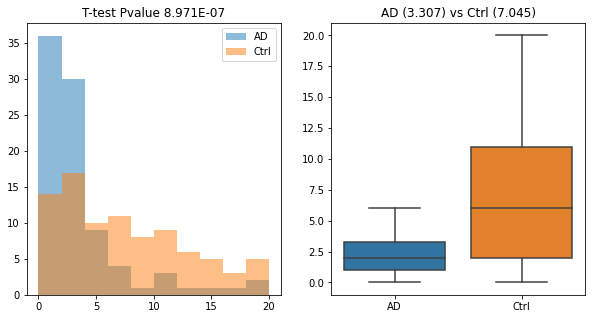

In [81]:
pval = ttest_ind(ncpts_ADs_selected, ncpts_ctrls_selected, equal_var=False).pvalue

plt.figure(figsize=[10, 5])
plt.subplot(121)
plt.hist(ncpts_ADs_selected, alpha=0.5, label="AD")
plt.hist(ncpts_ctrls_selected, alpha=0.5, label="Ctrl")
plt.title(f"T-test Pvalue {pval:.3E}")
plt.legend()

plt.subplot(122)
sns.boxplot(data=[ncpts_ADs_selected, ncpts_ctrls_selected], showfliers=0)
plt.xticks([0, 1], ["AD", "Ctrl"]);
plt.title(f"AD ({ncpts_ADs_selected.mean():.3f}) vs Ctrl ({ncpts_ctrls_selected.mean():.3f})")

Text(0.5, 1.0, 'AD (5.761) vs Ctrl (5.170)')

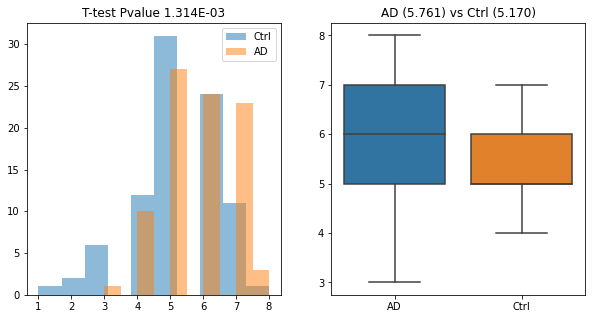

In [82]:
rank_ADs = np.array([len(cumsum_cutoff(np.abs(CPDresult_AD[2][ix]), paras.cutoff)) for ix in range(len(CPDresult_AD[2]))])
rank_ctrls = np.array([len(cumsum_cutoff(np.abs(CPDresult_ctrl[2][ix]), paras.cutoff)) for ix in range(len(CPDresult_ctrl[2]))])

pval = ttest_ind(rank_ADs, rank_ctrls, equal_var=False).pvalue

plt.figure(figsize=[10, 5])
plt.subplot(121)
plt.hist(rank_ctrls, alpha=0.5, label="Ctrl")
plt.hist(rank_ADs, alpha=0.5, label="AD")
plt.title(f"T-test Pvalue {pval:.3E}")
plt.legend()

plt.subplot(122)
sns.boxplot(data=[rank_ADs, rank_ctrls], showfliers=0)
plt.xticks([0, 1], ["AD", "Ctrl"]);
plt.title(f"AD ({rank_ADs.mean():.3f}) vs Ctrl ({rank_ctrls.mean():.3f})")

### Re-estimate the lambdas for each segment

In [83]:
# Get the sigvals for each segment
def est_singular_vals(ecpts, ndXmat, nXmat):
    """
    Input: 
        ecpts: Estimated change points, 
        ndXmat: a rAct x n matrix
        nXmat: a rAct x n matrix
    Return:
        Estimated Singularvals, r x (len(ecpts) + 1) 
    """
    r, n = ndXmat.shape
    ecptsfull = np.concatenate(([0], ecpts, [n])) - 1
    ecptsfull = ecptsfull.astype(int)
    numchgfull = len(ecptsfull)
    
    def _obtain_singular_vals(Ycur, Xcur):
        lams = np.zeros(r) + np.inf
        for iy in range(r):
            rY, rX = Ycur[iy, :], Xcur[iy, :]
            lam = (rY.dot(rX))/(rX.dot(rX))
            lams[iy] = lam
        return lams

    ResegS = np.zeros((numchgfull-1, r))
    for  itr in range(numchgfull-1):
        lower = ecptsfull[itr] + 1
        upper = ecptsfull[itr+1] + 1
        Ycur = ndXmat[:, lower:upper]
        Xcur = nXmat[:, lower:upper]
        ResegS[itr, :] = _obtain_singular_vals(Ycur, Xcur)
    
    return ResegS.T

In [84]:
singular_vals_ADs = []
singular_vals_ctrls = []

for ix in range(len(cpts_ADs_selected)):
    cur_singular_vals = est_singular_vals(cpts_ADs_selected[ix], ndXmats_AD[ix], nXmats_AD[ix])
    singular_vals_ADs.append(cur_singular_vals)
    
for ix in range(len(cpts_ctrls_selected)):
    cur_singular_vals = est_singular_vals(cpts_ctrls_selected[ix], ndXmats_ctrl[ix], nXmats_ctrl[ix])
    singular_vals_ctrls.append(cur_singular_vals)

In [111]:
cur_cutoff = paras.cutoff
# selected U and calculate weighted U (ABS wU)
wUs_abs_AD = []
wUs_abs_mean_AD = []
wUs_abs_max_AD = []
for ix in range(len(singular_vals_ADs)):
    cur_singular_val_abs = np.abs(singular_vals_ADs[ix])
    cur_keep_idx = keep_idxs_AD[ix]
    cur_dwells = dwells_ADs_selected[ix]
    
    cur_ws_abs = cur_singular_val_abs
    cur_Us_abs = np.abs(B1[:, cur_keep_idx])
    
    cur_wUs_abs = np.matmul(cur_Us_abs, cur_ws_abs)
    cur_wUs_abs_mean = cur_wUs_abs.mean(axis=1)
    
    wUs_abs_AD.append(cur_wUs_abs)
    wUs_abs_max_AD.append(cur_wUs_abs[:, np.argmax(cur_dwells)])
    wUs_abs_mean_AD.append(cur_wUs_abs_mean)
    
wUs_abs_ctrl = []
wUs_abs_mean_ctrl = []
wUs_abs_max_ctrl = []
for ix in range(len(singular_vals_ctrls)):
    cur_singular_val_abs = np.abs(singular_vals_ctrls[ix])
    cur_keep_idx = keep_idxs_ctrl[ix]
    cur_dwells = dwells_ctrls_selected[ix]
    
    cur_ws_abs = cur_singular_val_abs
    cur_Us_abs = np.abs(B1[:, cur_keep_idx])
    
    cur_wUs_abs = np.matmul(cur_Us_abs, cur_ws_abs)
    cur_wUs_abs_mean = cur_wUs_abs.mean(axis=1)
    
    wUs_abs_ctrl.append(cur_wUs_abs)
    wUs_abs_max_ctrl.append(cur_wUs_abs[:, np.argmax(cur_dwells)])
    wUs_abs_mean_ctrl.append(cur_wUs_abs_mean)
    
wUs_abs_mean_AD = np.array(wUs_abs_mean_AD)
wUs_abs_mean_ctrl = np.array(wUs_abs_mean_ctrl)
wUs_abs_max_AD = np.array(wUs_abs_max_AD)
wUs_abs_max_ctrl = np.array(wUs_abs_max_ctrl)

### Some simple classification

In [112]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [119]:
# prepare for Y and X
reg_Y = np.concatenate([np.ones_like(rank_ADs), np.zeros_like(rank_ctrls)])
reg_X_B3 = np.concatenate([
                minmax_mat(np.abs(CPDresult_AD[2]), is_row=True),
                minmax_mat(np.abs(CPDresult_ctrl[2]), is_row=True)
            ], axis=0)
reg_X_wU_abs_mean = np.concatenate([wUs_abs_mean_AD, wUs_abs_mean_ctrl], axis=0)
reg_X_wU_abs_max = np.concatenate([wUs_abs_max_AD, wUs_abs_max_ctrl], axis=0)
reg_X_rank = np.concatenate([rank_ADs, rank_ctrls])
reg_X_ncpts = np.concatenate([ncpts_ADs_selected, ncpts_ctrls_selected])


reg_X = np.concatenate([reg_X_rank.reshape(-1, 1), reg_X_ncpts.reshape(-1, 1)], axis=1)
reg_X = np.concatenate([reg_X_wU_abs_max, reg_X_rank.reshape(-1, 1), reg_X_ncpts.reshape(-1, 1)], axis=1)
#reg_X = reg_X_wU_abs_mean
reg_X_std = (reg_X - reg_X.mean(axis=0))/reg_X.std(axis=0)

In [120]:
# return the predicted probs for each test obs
def clf_2probs(clf, X_test):
    probs = clf.predict_proba(X_test)
    return probs[:, clf.classes_==1]

def LOO_pred_givenC(cur_X, cur_Y, C=1):
    probs = []
    for ix in trange(len(cur_Y)):
        cur_X_test = cur_X[ix, :].reshape(1, -1)
        cur_Y_test = cur_Y[ix].reshape(1, -1)
        cur_X_train = np.delete(cur_X, ix, axis=0)
        cur_Y_train = np.delete(cur_Y, ix)
        clf = LogisticRegression(random_state=0, C=C, penalty="l2", solver="liblinear").fit(cur_X_train, cur_Y_train)
        #clf = RandomForestClassifier(random_state=0).fit(cur_X_train, cur_Y_train)
        #clf = DecisionTreeClassifier(random_state=0).fit(cur_X_train, cur_Y_train)
        probs.append(clf_2probs(clf, cur_X_test))
    return np.array(probs).reshape(-1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 447.23it/s]


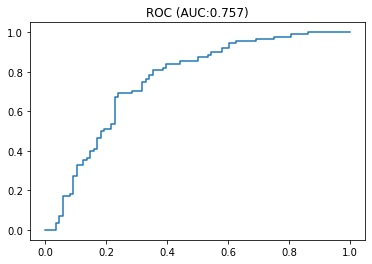

In [122]:
pred_probs = LOO_pred_givenC(reg_X_std, reg_Y, C=0.1)
fpr, tpr, thresholds = roc_curve(reg_Y, pred_probs, pos_label=1)
auc = roc_auc_score(reg_Y, pred_probs)

plt.title(f"ROC (AUC:{auc:.3f})")
plt.plot(fpr, tpr)

### Functional connectivity

<AxesSubplot:>

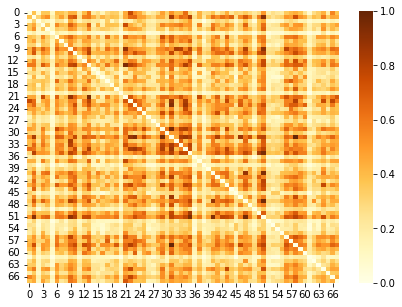

In [107]:
minmax = lambda x : (x-x.min())/(x.max()-x.min())
FC_raw_abs = np.abs(B1).dot(np.abs(B1).T)
FC_raw_abs_trans = minmax(FC_raw_abs - np.diag(np.diag(FC_raw_abs)) + np.diag(np.ones(68)*np.median(FC_raw_abs)))
FC_raw_abs_trans = FC_raw_abs_trans - np.diag(np.diag(FC_raw_abs_trans))

plt.figure(figsize=[7, 5])
sns.heatmap(FC_raw_abs_trans,  cmap="YlOrBr")